## Imports and Set up

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os

In [3]:
# specify the path of the dataset
path = '../data/'


# read the data from the path specified
trainprevloans = pd.read_csv(path + 'trainprevloans.csv')
trainperf = pd.read_csv(path + 'trainperf.csv')
traindemographics = pd.read_csv(path + 'traindemographics.csv')
testprevloans = pd.read_csv(path + 'testprevloans.csv')
testperf = pd.read_csv(path + 'testperf.csv')
testdemographics = pd.read_csv(path + 'testdemographics.csv')
ss = pd.read_csv(path + 'SampleSubmission.csv')

### Check Data Shapes

In [10]:
print(f'==========Train Data Shape report========== \nDemographics: \
{traindemographics.shape} \nPerformance: {trainperf.shape} \nPreviousLoans: {trainprevloans.shape}')

==========Train Data Shape report========== 
Demographics: (4346, 9) 
Performance: (4368, 10) 
PreviousLoans: (18183, 12)


In [11]:
print(f'==========Test Data Shape report========== \nDemographics: \
{testdemographics.shape} \nPerformance: {testperf.shape} \nPreviousLoans: {testprevloans.shape}')

==========Test Data Shape report========== 
Demographics: (1487, 9) 
Performance: (1450, 9) 
PreviousLoans: (5907, 12)


### Combine Train and Test datasets

In [12]:
#combine the train and test data of the related dataframes

prevloans = pd.concat([trainprevloans, testprevloans]).reset_index(drop=True)
performance = pd.concat([trainperf, testperf]).reset_index(drop=True)
demographics = pd.concat([traindemographics, testdemographics]).reset_index(drop=True)

demographics.shape, performance.shape, prevloans.shape

((5833, 9), (5818, 10), (24090, 12))

## Pre-Processing

In [13]:
# converting date columns to datetime type

datecols = [x for x in prevloans.columns.to_list() if 'date' in x]

for col in datecols:
    prevloans[col] = pd.to_datetime(prevloans[col])
    
# check the data types of the columns 
prevloans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24090 entries, 0 to 24089
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   customerid       24090 non-null  object        
 1   systemloanid     24090 non-null  int64         
 2   loannumber       24090 non-null  int64         
 3   approveddate     24090 non-null  datetime64[ns]
 4   creationdate     24090 non-null  datetime64[ns]
 5   loanamount       24090 non-null  float64       
 6   totaldue         24090 non-null  float64       
 7   termdays         24090 non-null  int64         
 8   closeddate       24090 non-null  datetime64[ns]
 9   referredby       1351 non-null   object        
 10  firstduedate     24090 non-null  datetime64[ns]
 11  firstrepaiddate  24090 non-null  datetime64[ns]
dtypes: datetime64[ns](5), float64(2), int64(3), object(2)
memory usage: 2.2+ MB


### Extract summarized information from the 'prevloans' data

In [19]:
# make a new dataframe

prevloan_data = pd.DataFrame(prevloans.customerid.unique(), columns=['customerid'])

In [20]:
# manually add columns for the new dataset
prevloan_data['loancount'] = ''
prevloan_data['totaldues'] = ''
prevloan_data['totalloans'] = ''
prevloan_data['maxloan'] = ''
prevloan_data['maxdue'] = ''
prevloan_data['maxterm'] = ''
prevloan_data['minterm'] = ''
prevloan_data['lastrepaid'] = ''
prevloan_data['minloan'] = ''
prevloan_data['mindue'] = ''

for val in prevloan_data.customerid.values:
    prevloan_data.at[prevloan_data[prevloan_data.customerid==val].index, 'loancount'] = max(prevloans[prevloans.customerid==val].loannumber)
    prevloan_data.at[prevloan_data[prevloan_data.customerid==val].index, 'totaldues'] = sum(prevloans[prevloans.customerid==val].totaldue)
    prevloan_data.at[prevloan_data[prevloan_data.customerid==val].index, 'totalloans'] = sum(prevloans[prevloans.customerid==val].loanamount)
    prevloan_data.at[prevloan_data[prevloan_data.customerid==val].index, 'maxloan'] = max(prevloans[prevloans.customerid==val].loanamount)
    prevloan_data.at[prevloan_data[prevloan_data.customerid==val].index, 'minloan'] = min(prevloans[prevloans.customerid==val].loanamount)
    prevloan_data.at[prevloan_data[prevloan_data.customerid==val].index, 'maxdue'] = max(prevloans[prevloans.customerid==val].totaldue)
    prevloan_data.at[prevloan_data[prevloan_data.customerid==val].index, 'mindue'] = min(prevloans[prevloans.customerid==val].totaldue)
    prevloan_data.at[prevloan_data[prevloan_data.customerid==val].index, 'maxterm'] = max(prevloans[prevloans.customerid==val].termdays)
    prevloan_data.at[prevloan_data[prevloan_data.customerid==val].index, 'minterm'] = min(prevloans[prevloans.customerid==val].termdays)
    prevloan_data.at[prevloan_data[prevloan_data.customerid==val].index, 'lastrepaid'] = max(prevloans[prevloans.customerid==val].firstrepaiddate)


#preview the sample of the data

prevloan_data.sample(5)

,customerid,loancount,totaldues,totalloans,maxloan,maxdue,maxterm,minterm,lastrepaid,minloan,mindue
5704,8a858f085b494826015b54a0b2a1093b,3,39000,30000,10000,13000,30,30,2017-06-30 23:21:09,10000,13000
3504,8a858eee58c2b6220158c4d7791c1a49,6,105050,90000,20000,24500,30,15,2017-07-03 04:27:42,10000,11500
1684,8a858f2c58dc6e680158e2d0956179ca,3,34500,30000,10000,11500,15,15,2017-05-24 11:58:10,10000,11500
3809,8a858e675c3fe0a1015c5315aaae176a,2,26000,20000,10000,13000,30,30,2017-07-28 12:45:20,10000,13000
4707,8a858f7e5c213ef4015c31640d15066c,1,13000,10000,10000,13000,30,30,2017-07-07 19:56:29,10000,13000


In [21]:
# add more date related columns

prevloan_data.lastrepaid = pd.to_datetime(prevloan_data.lastrepaid)
prevloan_data['lastrepaid_year'] = prevloan_data.lastrepaid.dt.year
prevloan_data['lastrepaid_month'] = prevloan_data.lastrepaid.dt.month
prevloan_data['lastrepaid_day'] = prevloan_data.lastrepaid.dt.day

# remove the original date column
prevloan_data = prevloan_data.drop(['lastrepaid'], axis=1)

prevloan_data.head()

,customerid,loancount,totaldues,totalloans,maxloan,maxdue,maxterm,minterm,minloan,mindue,lastrepaid_year,lastrepaid_month,lastrepaid_day
0,8a2a81a74ce8c05d014cfb32a0da1049,11,242900,200000,30000,34500,30,30,10000,13000,2017,7,25
1,8a8588f35438fe12015444567666018e,6,70500,60000,10000,13000,30,15,10000,11500,2017,5,26
2,8a85890754145ace015429211b513e16,2,24500,20000,10000,13000,30,15,10000,11500,2017,7,14
3,8a858970548359cc0154883481981866,8,188400,150000,30000,39000,60,30,10000,13000,2017,7,3
4,8a8589f35451855401546b0738c42524,7,124800,100000,20000,24500,30,30,10000,13000,2017,7,19


In [22]:
# check the shape of the new dataframe created

prevloan_data.shape

(5801, 13)

### Merge extracted Loan Data with the Performance DataFrame

In [23]:
# preview the newly created dataset

prevloan_data.head()

,customerid,loancount,totaldues,totalloans,maxloan,maxdue,maxterm,minterm,minloan,mindue,lastrepaid_year,lastrepaid_month,lastrepaid_day
0,8a2a81a74ce8c05d014cfb32a0da1049,11,242900,200000,30000,34500,30,30,10000,13000,2017,7,25
1,8a8588f35438fe12015444567666018e,6,70500,60000,10000,13000,30,15,10000,11500,2017,5,26
2,8a85890754145ace015429211b513e16,2,24500,20000,10000,13000,30,15,10000,11500,2017,7,14
3,8a858970548359cc0154883481981866,8,188400,150000,30000,39000,60,30,10000,13000,2017,7,3
4,8a8589f35451855401546b0738c42524,7,124800,100000,20000,24500,30,30,10000,13000,2017,7,19


In [24]:
# preview the performance dataset

performance.head()

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,referredby,good_bad_flag
0,8a2a81a74ce8c05d014cfb32a0da1049,301994762,12,2017-07-25 08:22:56.000000,2017-07-25 07:22:47.000000,30000.0,34500.0,30,NaN,Good
1,8a85886e54beabf90154c0a29ae757c0,301965204,2,2017-07-05 17:04:41.000000,2017-07-05 16:04:18.000000,15000.0,17250.0,30,NaN,Good
2,8a8588f35438fe12015444567666018e,301966580,7,2017-07-06 14:52:57.000000,2017-07-06 13:52:51.000000,20000.0,22250.0,15,NaN,Good
3,8a85890754145ace015429211b513e16,301999343,3,2017-07-27 19:00:41.000000,2017-07-27 18:00:35.000000,10000.0,11500.0,15,NaN,Good
4,8a858970548359cc0154883481981866,301962360,9,2017-07-03 23:42:45.000000,2017-07-03 22:42:39.000000,40000.0,44000.0,30,NaN,Good


In [25]:
# merge performance and loan data

perf_loandata = pd.merge(left=performance, right=prevloan_data, how='left', on='customerid')

# check the shape after merge
print(perf_loandata.shape)

# preview the new dataset
perf_loandata.head()

(5818, 22)


,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,referredby,good_bad_flag,...,totalloans,maxloan,maxdue,maxterm,minterm,minloan,mindue,lastrepaid_year,lastrepaid_month,lastrepaid_day
0,8a2a81a74ce8c05d014cfb32a0da1049,301994762,12,2017-07-25 08:22:56.000000,2017-07-25 07:22:47.000000,30000.0,34500.0,30,NaN,Good,...,200000,30000,34500,30,30,10000,13000,2017.0,7.0,25.0
1,8a85886e54beabf90154c0a29ae757c0,301965204,2,2017-07-05 17:04:41.000000,2017-07-05 16:04:18.000000,15000.0,17250.0,30,NaN,Good,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,8a8588f35438fe12015444567666018e,301966580,7,2017-07-06 14:52:57.000000,2017-07-06 13:52:51.000000,20000.0,22250.0,15,NaN,Good,...,60000,10000,13000,30,15,10000,11500,2017.0,5.0,26.0
3,8a85890754145ace015429211b513e16,301999343,3,2017-07-27 19:00:41.000000,2017-07-27 18:00:35.000000,10000.0,11500.0,15,NaN,Good,...,20000,10000,13000,30,15,10000,11500,2017.0,7.0,14.0
4,8a858970548359cc0154883481981866,301962360,9,2017-07-03 23:42:45.000000,2017-07-03 22:42:39.000000,40000.0,44000.0,30,NaN,Good,...,150000,30000,39000,60,30,10000,13000,2017.0,7.0,3.0


In [26]:
# extract the date columns
datecols_2 = [x for x in perf_loandata.columns.tolist() if 'date' in x]

# remove unwanted columns
perf_loandata = perf_loandata.drop(datecols_2, axis=1)
perf_loandata = perf_loandata.drop(['referredby'], axis=1)
perf_loandata = perf_loandata.drop(['systemloanid'], axis=1)

# preview the dataset
perf_loandata.head()

,customerid,loannumber,loanamount,totaldue,termdays,good_bad_flag,loancount,totaldues,totalloans,maxloan,maxdue,maxterm,minterm,minloan,mindue,lastrepaid_year,lastrepaid_month,lastrepaid_day
0,8a2a81a74ce8c05d014cfb32a0da1049,12,30000.0,34500.0,30,Good,11,242900,200000,30000,34500,30,30,10000,13000,2017.0,7.0,25.0
1,8a85886e54beabf90154c0a29ae757c0,2,15000.0,17250.0,30,Good,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,8a8588f35438fe12015444567666018e,7,20000.0,22250.0,15,Good,6,70500,60000,10000,13000,30,15,10000,11500,2017.0,5.0,26.0
3,8a85890754145ace015429211b513e16,3,10000.0,11500.0,15,Good,2,24500,20000,10000,13000,30,15,10000,11500,2017.0,7.0,14.0
4,8a858970548359cc0154883481981866,9,40000.0,44000.0,30,Good,8,188400,150000,30000,39000,60,30,10000,13000,2017.0,7.0,3.0


In [27]:
# change the datatype of the manually added columns to float

for col in perf_loandata.columns.difference(['customerid', 'good_bad_flag']).tolist():
    perf_loandata[col] = perf_loandata[col].astype('float')

In [28]:
# checkpoint, make a copy of the merged data

data = perf_loandata.copy()

### Merge the resulting Data with Demographics data

In [29]:
# preview the demographics data
demographics.head()

,customerid,birthdate,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,bank_branch_clients,employment_status_clients,level_of_education_clients
0,8a858e135cb22031015cbafc76964ebd,1973-10-10 00:00:00.000000,Savings,3.319219,6.528604,GT Bank,NaN,NaN,NaN
1,8a858e275c7ea5ec015c82482d7c3996,1986-01-21 00:00:00.000000,Savings,3.325598,7.119403,Sterling Bank,NaN,Permanent,NaN
2,8a858e5b5bd99460015bdc95cd485634,1987-04-01 00:00:00.000000,Savings,5.746100,5.563174,Fidelity Bank,NaN,NaN,NaN
3,8a858efd5ca70688015cabd1f1e94b55,1991-07-19 00:00:00.000000,Savings,3.362850,6.642485,GT Bank,NaN,Permanent,NaN
4,8a858e785acd3412015acd48f4920d04,1982-11-22 00:00:00.000000,Savings,8.455332,11.971410,GT Bank,NaN,Permanent,NaN


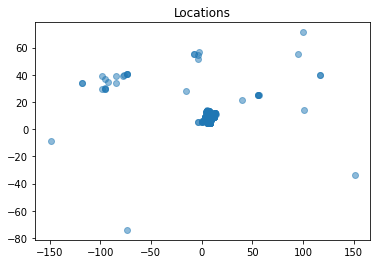

In [36]:
# visualize the locations from the demographics dataset

plt.scatter(x=demographics.longitude_gps, y=demographics.latitude_gps, alpha=0.5)
plt.title('Locations')
plt.show()

### the locations are mostly scattered but most ones are at around 0,0

### preprocess the demographics data

In [37]:
import time

# convert the date columns type to datetime
demographics.birthdate = pd.to_datetime(demographics.birthdate)

# add more date features
demographics['birth_year'] = demographics.birthdate.dt.year
demographics['birth_month'] = demographics.birthdate.dt.month
demographics['customer_age'] = (time.localtime().tm_year) - demographics.birth_year

#drop unwanted columns
demographics = demographics.drop(['bank_branch_clients', 'birthdate', 'level_of_education_clients',
                                  'longitude_gps', 'latitude_gps'
                                  ], axis=1)

# preview the dataset
demographics.head()

,customerid,bank_account_type,bank_name_clients,employment_status_clients,birth_year,birth_month,customer_age
0,8a858e135cb22031015cbafc76964ebd,Savings,GT Bank,NaN,1973,10,49
1,8a858e275c7ea5ec015c82482d7c3996,Savings,Sterling Bank,Permanent,1986,1,36
2,8a858e5b5bd99460015bdc95cd485634,Savings,Fidelity Bank,NaN,1987,4,35
3,8a858efd5ca70688015cabd1f1e94b55,Savings,GT Bank,Permanent,1991,7,31
4,8a858e785acd3412015acd48f4920d04,Savings,GT Bank,Permanent,1982,11,40


In [38]:
# preview the percentages of missing values from the demographics data

(demographics.isnull().sum()/demographics.shape[0]).sort_values(ascending=False)

employment_status_clients    0.148294
customer_age                 0.000000
birth_month                  0.000000
birth_year                   0.000000
bank_name_clients            0.000000
bank_account_type            0.000000
customerid                   0.000000
dtype: float64

In [39]:
# specify categorical columns
cat_cols = ['bank_account_type', 'bank_name_clients', 'employment_status_clients']

# fill the missing values in status_clients with'unknown' 
demographics.employment_status_clients = demographics.employment_status_clients.fillna('unknown')


# label encode the rest of the categorical columns
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

for col in cat_cols:
    demographics[col] = le.fit_transform(demographics[col])

# preview the demographics data
demographics.head()

,customerid,bank_account_type,bank_name_clients,employment_status_clients,birth_year,birth_month,customer_age
0,8a858e135cb22031015cbafc76964ebd,2,6,6,1973,10,49
1,8a858e275c7ea5ec015c82482d7c3996,2,12,1,1986,1,36
2,8a858e5b5bd99460015bdc95cd485634,2,4,6,1987,4,35
3,8a858efd5ca70688015cabd1f1e94b55,2,6,1,1991,7,31
4,8a858e785acd3412015acd48f4920d04,2,6,1,1982,11,40


In [24]:
# # encode the categorical columns using dummies

# demographics = pd.get_dummies(data=demographics, columns=cat_cols)
# demographics.head()

,customerid,longitude_gps,latitude_gps,birth_year,birth_month,customer_age,bank_account_type_0,bank_account_type_1,bank_account_type_2,bank_name_clients_0,...,bank_name_clients_15,bank_name_clients_16,bank_name_clients_17,employment_status_clients_0,employment_status_clients_1,employment_status_clients_2,employment_status_clients_3,employment_status_clients_4,employment_status_clients_5,employment_status_clients_6
0,8a858e135cb22031015cbafc76964ebd,3.319219,6.528604,1973,10,49,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,8a858e275c7ea5ec015c82482d7c3996,3.325598,7.119403,1986,1,36,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
2,8a858e5b5bd99460015bdc95cd485634,5.746100,5.563174,1987,4,35,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
3,8a858efd5ca70688015cabd1f1e94b55,3.362850,6.642485,1991,7,31,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
4,8a858e785acd3412015acd48f4920d04,8.455332,11.971410,1982,11,40,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0


### Merge the demographics data with the previous merged data (prevloans + performance)

In [40]:
# merge the data

data = pd.merge(left=perf_loandata, right=demographics, how='left', on='customerid')

print(data.shape)
data.head()

(5833, 24)


,customerid,loannumber,loanamount,totaldue,termdays,good_bad_flag,loancount,totaldues,totalloans,maxloan,...,mindue,lastrepaid_year,lastrepaid_month,lastrepaid_day,bank_account_type,bank_name_clients,employment_status_clients,birth_year,birth_month,customer_age
0,8a2a81a74ce8c05d014cfb32a0da1049,12.0,30000.0,34500.0,30.0,Good,11.0,242900.0,200000.0,30000.0,...,13000.0,2017.0,7.0,25.0,1,1,1,1972,1,50
1,8a85886e54beabf90154c0a29ae757c0,2.0,15000.0,17250.0,30.0,Good,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2,6,1,1985,8,37
2,8a8588f35438fe12015444567666018e,7.0,20000.0,22250.0,15.0,Good,6.0,70500.0,60000.0,10000.0,...,11500.0,2017.0,5.0,26.0,1,2,1,1984,9,38
3,8a85890754145ace015429211b513e16,3.0,10000.0,11500.0,15.0,Good,2.0,24500.0,20000.0,10000.0,...,11500.0,2017.0,7.0,14.0,2,5,1,1977,10,45
4,8a858970548359cc0154883481981866,9.0,40000.0,44000.0,30.0,Good,8.0,188400.0,150000.0,30000.0,...,13000.0,2017.0,7.0,3.0,1,6,1,1986,9,36


In [41]:
# change data types of the categorical columns

for col in cat_cols:
    data[col] = data[col].astype('int64')

## Modelling

In [42]:
train_df = data[data.good_bad_flag.notnull()]
test_df = data[data.good_bad_flag.isnull()]

train_df = train_df.fillna(-999)

test_df = test_df.fillna(-999)

train_df.shape, test_df.shape

((4379, 24), (1454, 24))

In [58]:
from sklearn.model_selection import train_test_split as tts

X = train_df.drop(['customerid', 'good_bad_flag'], axis=1)
y = train_df.good_bad_flag

### Training and Evaluation

In [64]:
from sklearn.model_selection import StratifiedKFold as SKF
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import roc_auc_score

SEED=0

main_cols = test_df.columns.difference(['customerid', 'good_bad_flag']).tolist()

score = 0
test_df['good_bad_flag'] = 0
skf = SKF(n_splits=5, shuffle=True, random_state=SEED)
oof_cat = np.zeros((X.shape[0],))
cat_preds= []
for fold_, (trn_idx, val_idx) in enumerate(skf.split(X, y)):
    print('Fold:',fold_+1)
        
    # Creating lgb train/valid data
    X_train, y_train = X.iloc[trn_idx,:], y[trn_idx] 
    X_test, y_test = X.iloc[val_idx,:], y[val_idx] 
       
    estimator = CatBoostClassifier(
                                    learning_rate=0.05,
                                    iterations=100, eval_metric='AUC',
                                    use_best_model =True,
                                    verbose=100,
                                    random_seed= SEED
                                  )
    
    estimator.fit(Pool(
                        X_train,y_train,
                        # cat_features = cat_cols
                        ),
                      eval_set = Pool(
                                      X_test,
                                      y_test,
                                      # cat_features = cat_cols
                                      ),
                      early_stopping_rounds=200
                      )
    
    y_pred_val = estimator.predict_proba(X_test)[:,1]
    oof_cat[val_idx] = y_pred_val
    score = score + roc_auc_score(y_test, y_pred_val)
    y_pred_test = estimator.predict_proba(test_df[main_cols])[:,1]
    cat_preds.append(y_pred_test)
print('OOF score :',roc_auc_score(y, oof_cat)) 

Fold: 1
0:	test: 0.5937440	best: 0.5937440 (0)	total: 3.81ms	remaining: 377ms
99:	test: 0.6642794	best: 0.6657851 (82)	total: 480ms	remaining: 0us

bestTest = 0.6657851492
bestIteration = 82

Shrink model to first 83 iterations.
Fold: 2
0:	test: 0.5762372	best: 0.5762372 (0)	total: 5.11ms	remaining: 506ms
99:	test: 0.6370161	best: 0.6373295 (85)	total: 459ms	remaining: 0us

bestTest = 0.6373294608
bestIteration = 85

Shrink model to first 86 iterations.
Fold: 3
0:	test: 0.5880957	best: 0.5880957 (0)	total: 3.76ms	remaining: 372ms
99:	test: 0.6413230	best: 0.6483013 (71)	total: 463ms	remaining: 0us

bestTest = 0.6483012955
bestIteration = 71

Shrink model to first 72 iterations.
Fold: 4
0:	test: 0.5404938	best: 0.5404938 (0)	total: 5.25ms	remaining: 519ms
99:	test: 0.6087744	best: 0.6094470 (89)	total: 487ms	remaining: 0us

bestTest = 0.6094470134
bestIteration = 89

Shrink model to first 90 iterations.
Fold: 5
0:	test: 0.5467691	best: 0.5467691 (0)	total: 16.9ms	remaining: 1.67s
99:	te

### Submission

In [66]:
# process predictions
preds_ = np.mean(cat_preds, axis=0)

preds = [0 if x<0.5 else 1 for x in preds_]

# make a submission dataframe
sub = pd.DataFrame({'customerid':test_df.customerid, 'Good_Bad_flag':preds})

sub_path = '../subs/'

# export the submission file
sub.to_csv(sub_path + 'catboost_lr05.csv', index=False)

sub.head()

,customerid,Good_Bad_flag
4379,8a858899538ddb8e015390510b321f08,1
4380,8a858959537a097401537a4e316e25f7,1
4381,8a8589c253ace09b0153af6ba58f1f31,1
4382,8a858e095aae82b7015aae86ca1e030b,1
4383,8a858e225a28c713015a30db5c48383d,1


E:\_ProgramFIles\anaconda3\envs\tensorflow\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Good_Bad_flag', ylabel='count'>

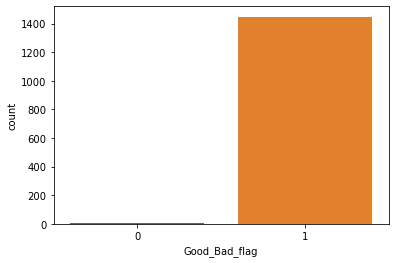

In [46]:
# visulaize the target predicted distribution

sns.countplot(sub.Good_Bad_flag)